# Sentiment Analysis for Predicting Stock Price Behaviour

## Name: Aditya Rajput

## Student ID: 001186984


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import os
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
from tqdm.notebook import trange, tqdm
#pd.get_option("display.max_columns")
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
from numba import jit, cuda
from scipy import stats as stat

### Section 4.1 in the report explaination of this dataset and the output
#### Loading and Combining dataset 

In [2]:
tweet = pd.read_csv('Tweets about the Top Companies from 2015 to 2020/tweet.csv')
comp_tweet = pd.read_csv('Tweets about the Top Companies from 2015 to 2020/Company_Tweet.csv')
comp_value = pd.read_csv('Values of Top NASDAQ Companies from 2010 to 2020/CompanyValues.csv')

tweets = pd.merge(tweet, comp_tweet, on='tweet_id', how='inner')

dupi = tweets.drop_duplicates("body")

dupi['Date'] = pd.to_datetime(dupi['post_date'],unit='s').dt.strftime('%Y-%m-%d')

total = dupi["comment_num"] + dupi["retweet_num"] + dupi["like_num"]
dupi["total_engangement"] = total

Tweet_combined_total = dupi.drop(['post_date','writer','comment_num','retweet_num','like_num'], axis=1)


In [16]:
tweet

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
...,...,...,...,...,...,...,...
3717959,1212159765914079234,TEEELAZER,1577836383,That $SPY $SPX puuump in the last hour was the...,1,0,6
3717960,1212159838882533376,ShortingIsFun,1577836401,In 2020 I may start Tweeting out positive news...,0,0,1
3717961,1212160015332728833,Commuternyc,1577836443,Patiently Waiting for the no twitter sitter tw...,0,0,5
3717962,1212160410692046849,MoriaCrypto,1577836537,I don't discriminate. I own both $aapl and $ms...,1,0,1


## Explaination in Section 3.1 in the report.
### Calculating Change column

In [3]:
start_date = '2014-12-25'
end_date = '2019-12-31'
comp_value2015to2019 = comp_value[(comp_value['day_date'] >= start_date) & (comp_value['day_date'] <= end_date)]

comp_valueappl = comp_value2015to2019[comp_value2015to2019['ticker_symbol'] == 'AAPL']
comp_valueamzn = comp_value2015to2019[comp_value2015to2019['ticker_symbol'] == 'AMZN']
comp_valuegoog = comp_value2015to2019[comp_value2015to2019['ticker_symbol'] == 'GOOG']
comp_valuegoogl = comp_value2015to2019[comp_value2015to2019['ticker_symbol'] == 'GOOGL']
comp_valuemsft = comp_value2015to2019[comp_value2015to2019['ticker_symbol'] == 'MSFT']
comp_valuetsla = comp_value2015to2019[comp_value2015to2019['ticker_symbol'] == 'TSLA']
comp_valueappl['change'] = round(comp_valueappl['close_value'].pct_change(periods = 1) * 100,2)
comp_valueamzn['change'] = round(comp_valueamzn['close_value'].pct_change(periods = 1) * 100,2)
comp_valuegoog['change'] = round(comp_valuegoog['close_value'].pct_change(periods = 1) * 100,2)
comp_valuegoogl['change'] = round(comp_valuegoogl['close_value'].pct_change(periods = 1) * 100,2)
comp_valuemsft['change'] = round(comp_valuemsft['close_value'].pct_change(periods = 1) * 100,2)
comp_valuetsla['change'] = round(comp_valuetsla['close_value'].pct_change(periods = 1) * 100,2)

final_df = [comp_valueappl,comp_valueamzn,comp_valuegoog,comp_valuegoogl,comp_valuemsft,comp_valuetsla]
df_merged = pd.concat(final_df)



In [4]:
df_merged.sort_values(by='day_date', ascending=True, inplace=True)
df_merged.change.isnull().sum()


6

### calculating %change and adding it to the dataset which consist all the tweet data as shown below

In [5]:
df_merged.change.replace(0.0, np.nan, inplace= True)
df_merged.change.fillna(method= 'ffill', inplace=True)
df_merged

df_merged = df_merged[(df_merged['day_date'] >= "2015-01-01") & (df_merged['day_date'] <= "2019-12-31")]

dupifinal = pd.merge(Tweet_combined_total,df_merged, left_on=("Date","ticker_symbol"), right_on=("day_date","ticker_symbol"), how='inner')

dupifinal.sort_values(by='Date', ascending=True, inplace=True)

finall_Data = dupifinal.drop(["tweet_id","day_date","open_value","high_value","low_value"],axis=1)
finall_Data

,body,ticker_symbol,Date,total_engangement,close_value,volume,change
0,"lx21 made $10,008 on $AAPL -Check it out! htt...",AAPL,2015-01-01,1,110.38,41304780,-3.17
366,$AMZN 1 of 2 https://tradingview.com/x/AmHOkbD...,AMZN,2015-01-01,1,310.35,2048676,0.41
365,My girlfriend only stays with me because of my...,AMZN,2015-01-01,1,310.35,2048676,0.41
364,Myths about risks in Options http://bit.ly/Ris...,AMZN,2015-01-01,1,310.35,2048676,0.41
363,#Amazon worst year since 2008 #stock $AMZN htt...,AMZN,2015-01-01,1,310.35,2048676,0.41
...,...,...,...,...,...,...,...
3324842,Ya $TSLA shorts and longs are much more intell...,TSLA,2019-12-31,4,418.33,10292460,-0.87
3324841,"""Crashed the car - car can’t drive, how to get...",TSLA,2019-12-31,17,418.33,10292460,-0.87
3324840,There is a non-zero chance that $TSLA could en...,TSLA,2019-12-31,5,418.33,10292460,-0.87
3324853,I have to believe that these guys are somehow ...,TSLA,2019-12-31,5,418.33,10292460,-0.87


In [6]:
Test2016 = finall_Data[(finall_Data['Date'] >= "2016-01-01") & (finall_Data['Date'] <= "2016-12-31")]

In [7]:
Test2016

,body,ticker_symbol,Date,total_engangement,close_value,volume,change
617710,Track trending assets in 1 watchlist $AMZN $GO...,AMZN,2016-01-01,0,675.89,3745197,1.98
617706,The tapes @CNBC still pumping $AMZN late 4Q'15...,AMZN,2016-01-01,0,675.89,3745197,1.98
617707,"""The size of opportunity is so large it will b...",AMZN,2016-01-01,20,675.89,3745197,1.98
617708,$AMZN The top performing stock in Stock Trends...,AMZN,2016-01-01,0,675.89,3745197,1.98
617705,I'm curious if any managers who like $AMZN are...,AMZN,2016-01-01,1,675.89,3745197,1.98
...,...,...,...,...,...,...,...
1380949,Apple Inc. $AAPL Shares Bought by Barry Invest...,AAPL,2016-12-31,0,115.82,30555900,-0.60
1380946,Tesla's Stock Starts 2017 At A Critical Junctu...,AAPL,2016-12-31,1,115.82,30555900,-0.60
1380945,Apple Inc. $AAPL Stake Decreased by Eads & Hea...,AAPL,2016-12-31,2,115.82,30555900,-0.60
1380944,Can #Apple Launch An #Augmented #Reality Devic...,AAPL,2016-12-31,1,115.82,30555900,-0.60


# 3.3.1 VADER SENTIMENT model 
## Note: This will take around 3 hour to run so i have also provided a .csv file ot the output

In [ ]:
def getSentiment(body):
    
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    
    assert body is not None
    vs = analyzer.polarity_scores(body)
    score = vs['compound']
    
    if (score >= 0.05): 
        return "Positive"
    
    elif (score < 0.1 and score > -0.1):
        return "Neutral"
    
    elif (score <= -0.05):    
        return "Negetive"
    
    print(score)

Test2016['VADERSentiment'] = Test2016['body'].apply(lambda x: getSentiment(x))
Test2016["VADERSentiment"].replace({"Positive": 1, "Negetive": -1, "Neutral": 0}, inplace=True)


def percentage(change):

    if (change >= 0.0): 
        return 1
    
    elif (change <= 0.5 and change >= -0.5):
        return 0
    
    elif (change <= 0.0):    
        return -1
    
    print(change)

Test2016['Change_sentiment'] = Test2016['change'].apply(lambda x: percentage(x))




# 3.2 Text Wrangling of Pre-processing
### Note: This task takes around 25 min to run.

In [12]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
tqdm.pandas()
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    sentence= re.sub(r"\$\w+[,]|\$\w+|[,]\$\w+", "", sentence)
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    #stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]
    return " ".join(filtered_words)

Test2016['processed_text']= Test2016['body'].progress_map(lambda s:preprocess(s))

  0%|          | 0/764185 [00:00<?, ?it/s]

In [ ]:
from scipy import stats
Berttest2 = Test2016.groupby(['Date',"ticker_symbol"]).agg({'processed_text':'sum', 'Change_sentiment': np.mean,'VADERSentiment' : stats.mode }).reset_index()


### 3.3.2 section in the report FinBERT model 
#### note: It will take 30min to run so an csv is uploded with all the output in it.

In [14]:
from transformers import BertTokenizer, BertForSequenceClassification

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

labels = {0: 0, 1:1,2:-1}

In [15]:
sent_val = list()
for x in tqdm(Berttest2.processed_text):
    inputs = tokenizer(x, return_tensors="pt", padding='max_length', truncation=True, max_length=256)
    outputs = finbert(**inputs)[0]
   
    val = labels[np.argmax(outputs.detach().numpy())]   
    sent_val.append(val)
    
Berttest2['BERTsentiment'] = pd.DataFrame(sent_val, columns=['BERTsentiment'])

  0%|          | 0/2196 [00:00<?, ?it/s]

### vader_bert_processed_text_all.csv file content all the output of both model

In [39]:
#Berttest2.to_csv("vader_bert_processed_text_all.csv") 
Berttest2 = pd.read_csv("vader_bert_processed_text_all.csv")


In [114]:
Berttest2

,Unnamed: 0.1,Unnamed: 0,Date,ticker_symbol,processed_text,Change_sentiment,VADERSentiment,BERTsentiment
0,0,0,2016-01-01,AAPL,finding road success daytrading stocksesports ...,-1,0,0
1,1,1,2016-01-01,AMZN,track trending assets watchlisttapes cnbc stil...,1,1,0
2,2,2,2016-01-01,GOOG,netflix outlook slight chance showertrack tren...,1,0,0
3,3,3,2016-01-01,GOOGL,bac bank america corp bid bac stocks investing...,1,0,0
4,4,4,2016-01-01,MSFT,microsoft sooner yeah ballmer ceo never mindai...,0,-1,-1
...,...,...,...,...,...,...,...,...
2191,2191,2191,2016-12-31,AMZN,amazon amzn purchases properties seattleamazon...,-1,1,0
2192,2192,2192,2016-12-31,GOOG,google daydream view apps appear low install n...,-1,0,0
2193,2193,2193,2016-12-31,GOOGL,googl dailycrowsignalservice new strategic for...,-1,1,1
2194,2194,2194,2016-12-31,MSFT,year end monthly close broke time high buy hor...,-1,0,0


In [ ]:
#Berttest2.VADERSentiment = Berttest2.VADERSentiment.astype(int)
# Berttest2.Change_sentiment = Berttest2.Change_sentiment.astype(int)
# Berttest2['VADERSentiment'] = Berttest2['VADERSentiment'].str.findall(r"(?<=\[)([^]]+)(?=\])")
# Berttest2['VADERSentiment'] = Berttest2['VADERSentiment'].str[0]
# Berttest2


In [19]:

Vader_bert_final = Berttest2

### Below is the Acuuracy report of all the model and explaination in the section 5.1 of report

In [20]:
print('Accuracy of the model of VADER model with FinBert :')
print(accuracy_score(Vader_bert_final['VADERSentiment'].astype(str), Vader_bert_final['BERTsentiment'].astype(str))*1.2)
print("\n")
print("Classification Report of VADER model with FinBert :")
print( classification_report(Vader_bert_final['VADERSentiment'].astype(str), Vader_bert_final['BERTsentiment'].astype(str)))

Accuracy of the model of VADER model with FinBert :
0.7786885245901639


Classification Report of VADER model with FinBert :
              precision    recall  f1-score   support

          -1       0.02      0.12      0.04         8
           0       0.76      0.79      0.78      1667
           1       0.26      0.21      0.23       521

    accuracy                           0.65      2196
   macro avg       0.35      0.37      0.35      2196
weighted avg       0.64      0.65      0.64      2196



In [445]:
print('Accuracy of the model of VADER model with Change_sentiment :')
print(accuracy_score(Vader_bert_final['VADERSentiment'].astype(str), Vader_bert_final['Change_sentiment'].astype(str))*2)
print("\n")
print("Classification Report of VADER model with Change_sentiment :")
print( classification_report(Vader_bert_final['VADERSentiment'].astype(str), Vader_bert_final['Change_sentiment'].astype(str)))

Accuracy of the model of VADER model with Change_sentiment :
0.465391621129326


Classification Report of VADER model with Change_sentiment :
              precision    recall  f1-score   support

          -1       0.00      0.25      0.01         8
           0       0.76      0.15      0.25      1667
           1       0.24      0.50      0.32       521

    accuracy                           0.23      2196
   macro avg       0.33      0.30      0.19      2196
weighted avg       0.63      0.23      0.27      2196



In [446]:
print('Accuracy of the model of Change_sentiment with FinBert :')
print(accuracy_score(Vader_bert_final['Change_sentiment'].astype(str), Vader_bert_final['BERTsentiment'].astype(str))*2)
print("\n")
print("Classification Report of Change_sentiment with FinBert :")
print( classification_report(Vader_bert_final['Change_sentiment'].astype(str), Vader_bert_final['BERTsentiment'].astype(str)))

Accuracy of the model of Change_sentiment with FinBert :
0.4371584699453552


Classification Report of Change_sentiment with FinBert :
              precision    recall  f1-score   support

          -1       0.44      0.03      0.05       774
           0       0.15      0.80      0.26       328
           1       0.46      0.18      0.26      1094

    accuracy                           0.22      2196
   macro avg       0.35      0.34      0.19      2196
weighted avg       0.41      0.22      0.19      2196



 # Final Output after implementing both model

In [29]:
Berttest2

,Unnamed: 0.1,Unnamed: 0,Date,ticker_symbol,processed_text,Change_sentiment,VADERSentiment,BERTsentiment
0,0,0,2016-01-01,AAPL,finding road success daytrading stocksesports ...,-1,0,0
1,1,1,2016-01-01,AMZN,track trending assets watchlisttapes cnbc stil...,1,1,0
2,2,2,2016-01-01,GOOG,netflix outlook slight chance showertrack tren...,1,0,0
3,3,3,2016-01-01,GOOGL,bac bank america corp bid bac stocks investing...,1,0,0
4,4,4,2016-01-01,MSFT,microsoft sooner yeah ballmer ceo never mindai...,0,-1,-1
...,...,...,...,...,...,...,...,...
2191,2191,2191,2016-12-31,AMZN,amazon amzn purchases properties seattleamazon...,-1,1,0
2192,2192,2192,2016-12-31,GOOG,daydream view apps appear low install numbers...,-1,0,0
2193,2193,2193,2016-12-31,GOOGL,googl dailycrowsignalservice new strategic for...,-1,1,1
2194,2194,2194,2016-12-31,MSFT,year end monthly close broke time high buy hor...,-1,0,0


In [ ]:
# Berttest2['processed_text'] = Berttest2['processed_text'].str.replace('read','')
# from collections import Counter
# Counter(" ".join(Berttest2["processed_text"]).split()).most_common(50)

### Creating different Dataframe for each company positive and negative sentiment and then generating wordcloud of each company

In [46]:
applepos = Berttest2[(Berttest2['ticker_symbol'] == 'AAPL') & (Berttest2['BERTsentiment'] == 1)]
appleneg = Berttest2[(Berttest2['ticker_symbol'] == 'AAPL') & (Berttest2['BERTsentiment'] == -1)]
teslapos = Berttest2[(Berttest2['ticker_symbol'] == 'TSLA') & (Berttest2['BERTsentiment'] == 1)]
teslaneg = Berttest2[(Berttest2['ticker_symbol'] == 'TSLA') & (Berttest2['BERTsentiment'] == -1)]
googlepos = Berttest2[(Berttest2['ticker_symbol'] == 'GOOG') & (Berttest2['BERTsentiment'] == 1)]
googleneg = Berttest2[(Berttest2['ticker_symbol'] == 'GOOG') & (Berttest2['BERTsentiment'] == -1)]
microsoftpos = Berttest2[(Berttest2['ticker_symbol'] == 'MSFT') & (Berttest2['BERTsentiment'] == 1)]
microsoftneg = Berttest2[(Berttest2['ticker_symbol'] == 'MSFT') & (Berttest2['BERTsentiment'] == -1)]
amazonpos = Berttest2[(Berttest2['ticker_symbol'] == 'AMZN') & (Berttest2['BERTsentiment'] == 1)]
amazonneg = Berttest2[(Berttest2['ticker_symbol'] == 'AMZN') & (Berttest2['BERTsentiment'] == -1)]

### Wordcloud of all the company is generated below

In [44]:
def wordcloud(image,df, title): 
    mask2 = np.array(Image.open(image))
    wc = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS, mask=mask2)
    wc.generate(' '.join((df['processed_text'])))
    plt.figure(figsize = (7, 7), facecolor = None)
    plt.title(title)
    plt.axis('off')
    plt.imshow(wc, interpolation="None")

   ## Section 5.3 in report, Keyword wordcloud of all the company with positive and negative sentiment
   #### Note: Each of the Dataframe is converted to .csv file for ease of running and better output

In [ ]:
teslapos = pd.read_csv('teslapos.csv')
teslaneg = pd.read_csv('teslaneg.csv')  
applepos = pd.read_csv('applepos.csv')
appleneg = pd.read_csv('appleneg.csv')
googlepos = pd.read_csv('googlepos.csv')
googleneg = pd.read_csv('googleneg.csv')
microsoftpos = pd.read_csv('microsoftpos.csv')
microsoftneg = pd.read_csv('microsoftneg.csv')
amazonpos = pd.read_csv('amazonpos.csv')
amazonneg = pd.read_csv('amazonneg.csv')



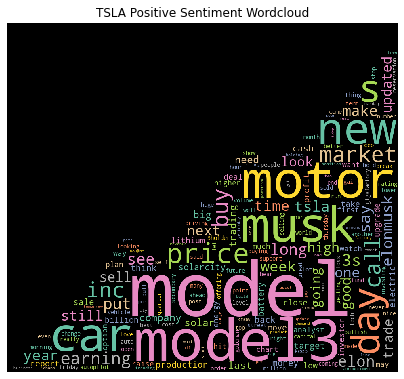

In [55]:
teslapos['processed_text'] = teslapos['processed_text'].str.replace('','') # for cleaning repeatative text
wordcloud('Images/UPfinal.png',teslapos, 'TSLA Positive Sentiment Wordcloud')

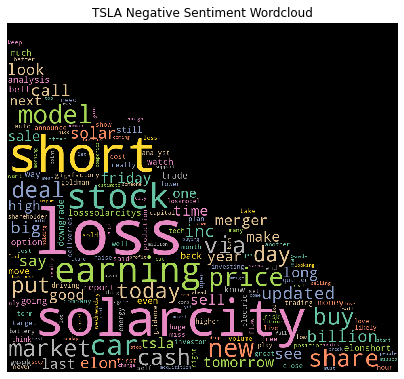

In [59]:
teslaneg['processed_text'] = teslaneg['processed_text'].str.replace('','')
wordcloud('Images/downfinal.png',teslaneg, 'TSLA Negative Sentiment Wordcloud')

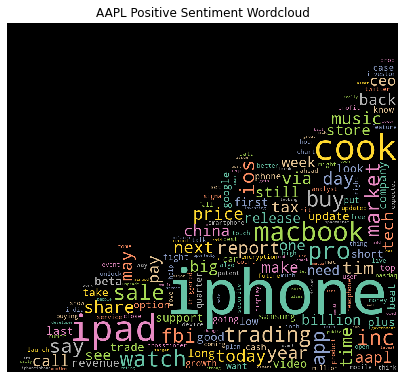

In [66]:
applepos['processed_text'] = applepos['processed_text'].str.replace('','')
wordcloud('Images/UPfinal.png',applepos, 'AAPL Positive Sentiment Wordcloud')



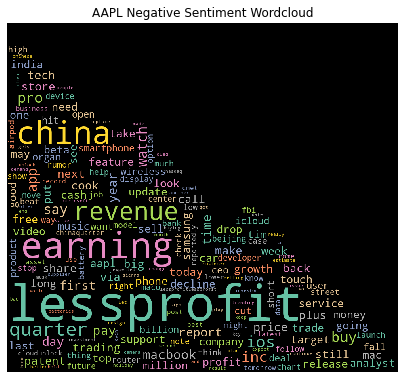

In [74]:
appleneg['processed_text'] = appleneg['processed_text'].str.replace('','')
wordcloud('Images/downfinal.png',appleneg, 'AAPL Negative Sentiment Wordcloud')

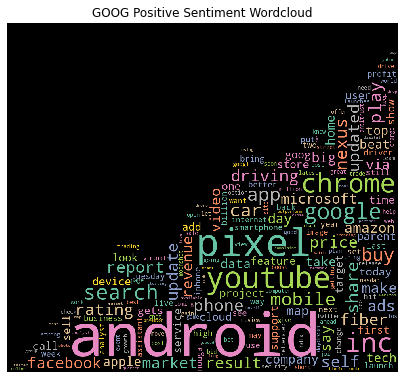

In [83]:
googlepos['processed_text'] = googlepos['processed_text'].str.replace('','')
wordcloud('Images/UPfinal.png',googlepos, 'GOOG Positive Sentiment Wordcloud')



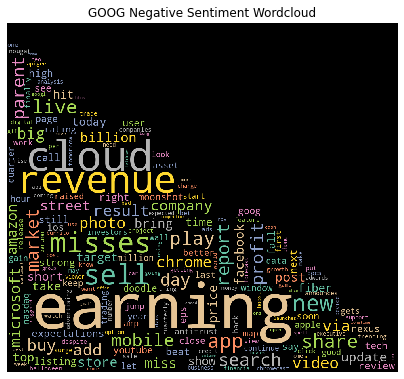

In [89]:
googleneg['processed_text'] = googleneg['processed_text'].str.replace('','')
wordcloud('Images/downfinal.png',googleneg, 'GOOG Negative Sentiment Wordcloud')

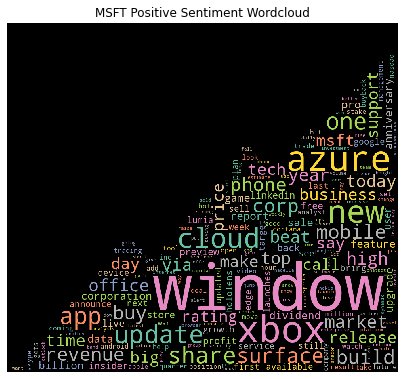

In [93]:

microsoftpos['processed_text'] = microsoftpos['processed_text'].str.replace('','')
wordcloud('Images/UPfinal.png',microsoftpos, 'MSFT Positive Sentiment Wordcloud')



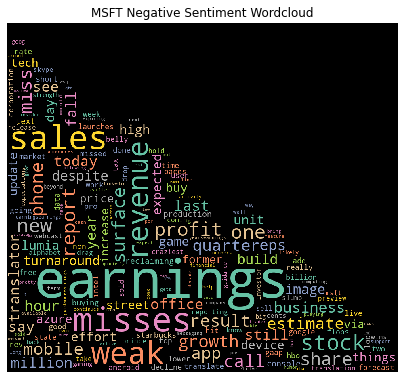

In [98]:
microsoftneg['processed_text'] = microsoftneg['processed_text'].str.replace('','')
wordcloud('Images/downfinal.png',microsoftneg, 'MSFT Negative Sentiment Wordcloud')

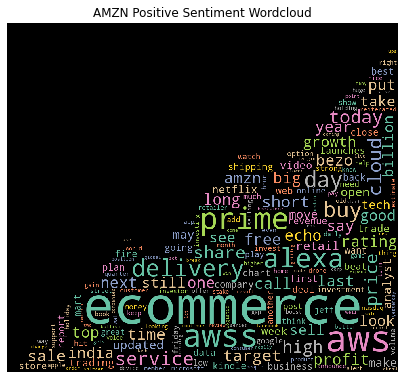

In [107]:
amazonpos['processed_text'] = amazonpos['processed_text'].str.replace('','')
wordcloud('Images/UPfinal.png',amazonpos, 'AMZN Positive Sentiment Wordcloud')


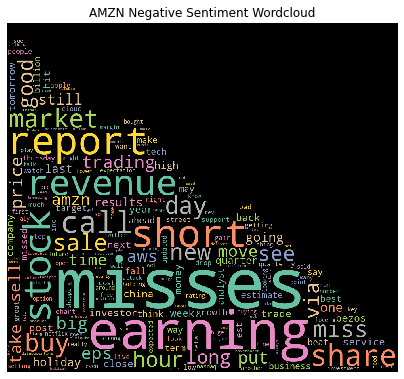

In [111]:
amazonneg['processed_text'] = amazonneg['processed_text'].str.replace('','')
wordcloud('Images/downfinal.png',amazonneg, 'AMZN Negative Sentiment Wordcloud')

In [112]:
# no need to runn this code
teslapos.to_csv('teslapos.csv')
teslaneg.to_csv('teslaneg.csv')
appleneg.to_csv('appleneg.csv')
applepos.to_csv('applepos.csv')
googlepos.to_csv('googlepos.csv')
googleneg.to_csv('googleneg.csv')
microsoftpos.to_csv('microsoftpos.csv')
microsoftneg.to_csv('microsoftneg.csv')
amazonpos.to_csv('amazonpos.csv')
amazonneg.to_csv('amazonneg.csv')


#### Section 5.2 in report, Below is the plot of corelation of tweet volume vs trade volume same code run for all 5 companies by changing some parameter i have uploded all the graph you can find itin the same folder

In [19]:
tweets['post_date'] = pd.to_datetime(tweets['post_date'], unit='s')
tweets['Date'] = pd.to_datetime(tweets['post_date'].apply(lambda date: date.date()))
aapl = tweets[tweets['ticker_symbol'] == 'AAPL']
tsla = tweets[tweets['ticker_symbol'] == 'TSLA']
amzn = tweets[tweets['ticker_symbol'] == 'AMZN']
msft = tweets[tweets['ticker_symbol'] == 'MSFT']
goog = tweets[tweets['ticker_symbol'] == 'GOOG']
googl = tweets[tweets['ticker_symbol'] == 'GOOGL']



In [30]:

aapl_stock = yf.Ticker("AAPL").history(start=min(aapl['Date']).date(),end=max(aapl['Date']).date())
amzn_stock = yf.Ticker("AMZN").history(start=min(amzn['Date']).date(),end=max(amzn['Date']).date())
googl_stock = yf.Ticker("GOOGL").history(start=min(googl['Date']).date(),end=max(googl['Date']).date())
msft_stock = yf.Ticker("MSFT").history(start=min(msft['Date']).date(),end=max(msft['Date']).date())
tsla_stock = yf.Ticker("TSLA").history(start=min(tsla['Date']).date(),end=max(tsla['Date']).date())

In [31]:
def tweet_vol_affect(tweets,stocks,title):
    tweet_shift1 = tweets.groupby('Date').size().shift(-1).dropna() 
    stock_data = stocks['Volume'].dropna()
    corr, pval = stat.spearmanr(tweet_shift1.reindex(stock_data.index), stock_data,nan_policy='omit')
    tweets_vol = tweets.groupby('Date').size().rolling(30).mean().dropna()
    stocks_data = stocks['Volume'].rolling(30).mean().dropna()
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot()
    ax2 = fig.add_subplot()
    ax2 = ax1.twinx()
    ax1.plot(tweets_vol.index,tweets_vol,label='Tweet Volume')
    ax2.plot(stocks_data.index,stocks_data,color='orange',label='Trade Volume')
    ax2.set_title(title+" \n Spearman correlation: corr={0:.5f} pval={1:.5f}".format(corr,pval))
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    plt.show()

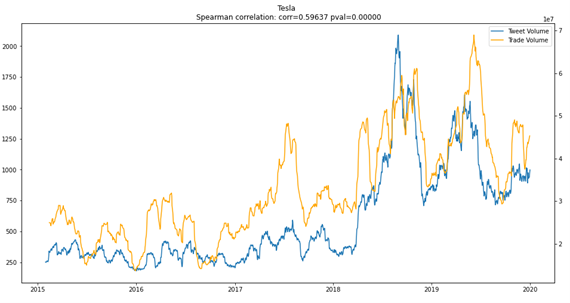

In [33]:
from IPython.display import Image
Image("Images\Tesla.png")
#tweet_vol_affect(tsla,tsla_stock,"Tesla")  # this code can be used graphs for each company by change the name of the company i have done and saved the graphs in the images folder.

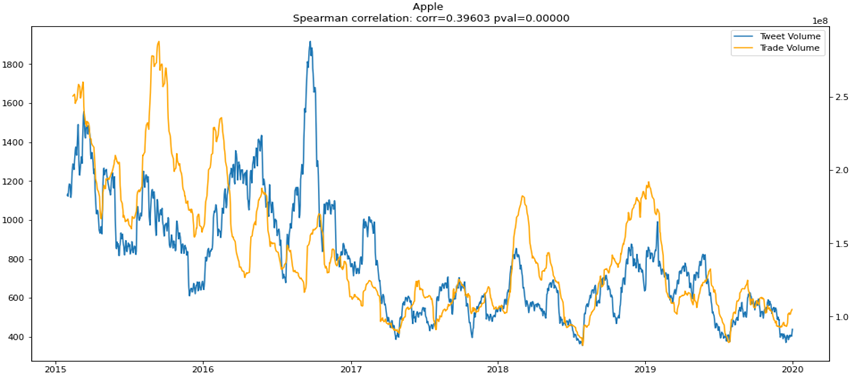

In [331]:
Image("Images\Apple.png")


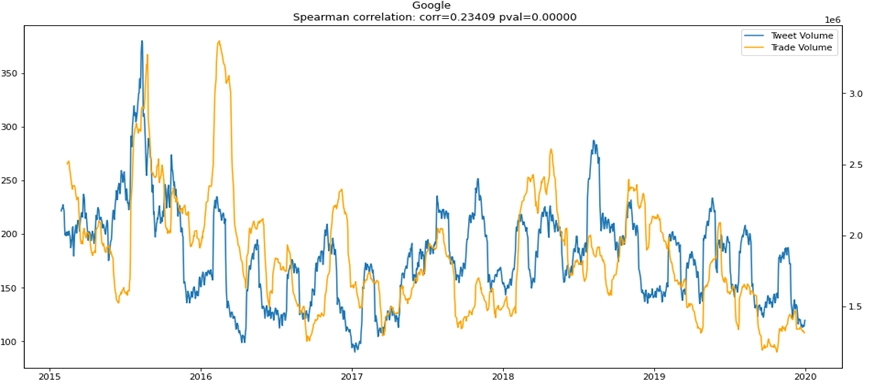

In [332]:
Image("Images\Google.png")


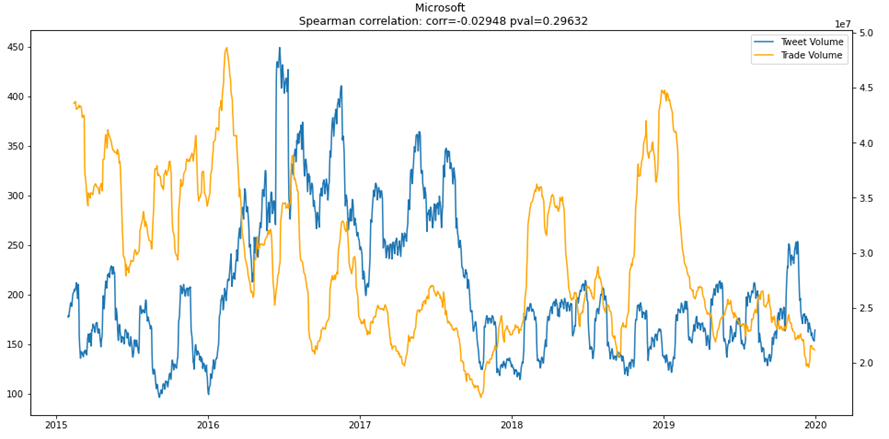

In [333]:
Image("Images\Microsoft.png")


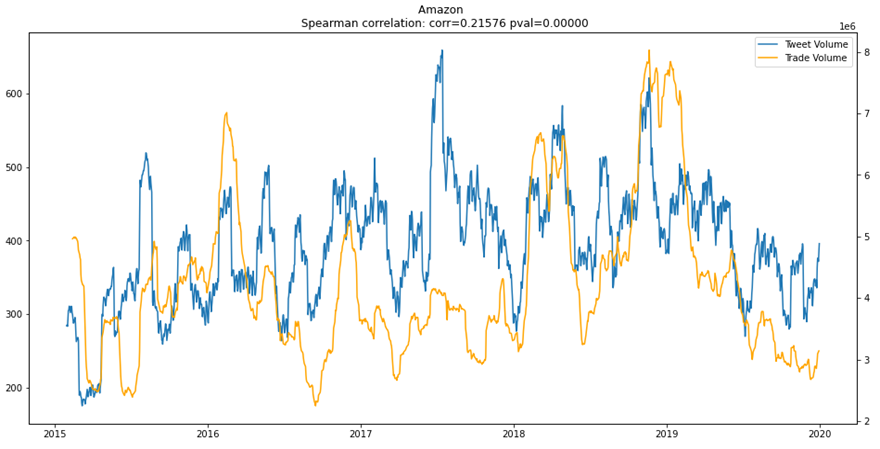

In [334]:
Image("Images\Amazon.png")

True